# Spotify Final Project
### Milestone 3: EDA and Baseline Model
### Austin Rochon, Emily Xie, and Mark Lock

In [1]:
# Import requisite packages
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#### Run this cell to load google cloud bigquery:

In [2]:
# Set up credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../config/spotted-d-d5e475a6e13e.json"

In [3]:
%load_ext google.cloud.bigquery

In [4]:
%%bigquery playlist_data
WITH cte AS (
  SELECT *, 
    ROW_NUMBER() OVER(PARTITION BY track_uri ORDER BY unique_pid) AS track_row
  FROM playlist_songs.playlist_tracks_joined_rand
  LIMIT 500000
)
SELECT * 
FROM cte
WHERE track_row = 1
LIMIT 100000

#### Data cleaning

First fetch only numeric data

In [5]:
# Pull in only audio features 
# https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
playlist_numeric = playlist_data.select_dtypes(include=numerics)
playlist_numeric["trackid"] = playlist_data["trackid"]
playlist_numeric = playlist_numeric.set_index("trackid")
playlist_numeric = playlist_numeric.drop(["index","pid", "pos", "unique_pid", "track_row", "random"], axis=1)
playlist_numeric.head()

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000l6tfhlwsgodb648EraF,0.479,0.684,6.0,-5.913,1.0,0.0797,0.19100,0.000003,0.106,0.413,85.419,190962.0,4.0
spotify:track:003U4oQXv82GYo1tNquN2F,0.538,0.770,7.0,-3.924,0.0,0.1030,0.00216,0.165000,0.355,0.235,170.035,299294.0,4.0
spotify:track:003tp162G8KIwWHSPAcNzS,0.800,0.497,2.0,-8.203,0.0,0.0362,0.00438,0.099600,0.074,0.329,110.996,220879.0,4.0
spotify:track:005IPSWvjzjh0j3Hv2i2Zw,0.506,0.951,0.0,-3.685,0.0,0.0420,0.01850,0.000186,0.370,0.722,148.001,220549.0,4.0
spotify:track:00CEFWfCqM0wXlfIJH0Sm0,0.458,0.916,2.0,-7.094,1.0,0.1340,0.00476,0.000300,0.967,0.298,98.284,941827.0,4.0


## Modeling

#### K-means for labeling
The first thing we'll want to do is find similarities between "groups" of songs in our data set. To do so, we'll first need to construct groups, using their audio properties as features to group them by. Before we begin, we need to normalize our data.

In [6]:
def normalize(df, scalar, features):
    # Split df into features and non-features
    non_feature_df = df[df.columns.difference(features)]
    feature_df = df[features]
    
    # Scale the features
    np_transform = scalar.transform(feature_df)
    df_transform = pd.DataFrame(np_transform, columns=features)

    # Merge back the features and non-features
    non_feature_df.reset_index(drop=True, inplace=True)
    df_transform.reset_index(drop=True, inplace=True)
    df_transform = pd.concat([non_feature_df, df_transform], axis = 1)
    
    return df_transform

In [12]:
# Fit MinMaxScalar and select features we will be using (all columns from playlist_numeric)
scalar = MinMaxScaler().fit(playlist_numeric)
features = playlist_numeric.columns

# Normalize data
playlist_norm = normalize(playlist_numeric, scalar, features)
playlist_norm["trackid"] = playlist_numeric.index
playlist_norm = playlist_norm.set_index("trackid")

# Drop NAs
playlist_norm = playlist_norm.dropna(how="all")

display(playlist_numeric.head())
display(playlist_norm.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000l6tfhlwsgodb648EraF,0.479,0.684,6.0,-5.913,1.0,0.0797,0.19100,0.000003,0.106,0.413,85.419,190962.0,4.0
spotify:track:003U4oQXv82GYo1tNquN2F,0.538,0.770,7.0,-3.924,0.0,0.1030,0.00216,0.165000,0.355,0.235,170.035,299294.0,4.0
spotify:track:003tp162G8KIwWHSPAcNzS,0.800,0.497,2.0,-8.203,0.0,0.0362,0.00438,0.099600,0.074,0.329,110.996,220879.0,4.0
spotify:track:005IPSWvjzjh0j3Hv2i2Zw,0.506,0.951,0.0,-3.685,0.0,0.0420,0.01850,0.000186,0.370,0.722,148.001,220549.0,4.0
spotify:track:00CEFWfCqM0wXlfIJH0Sm0,0.458,0.916,2.0,-7.094,1.0,0.1340,0.00476,0.000300,0.967,0.298,98.284,941827.0,4.0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
trackid,,,,,,,,,,,,,
spotify:track:000l6tfhlwsgodb648EraF,0.484818,0.684,0.545455,0.860641,1.0,0.082676,0.191767,0.000003,0.106,0.413,0.352081,0.039474,0.8
spotify:track:003U4oQXv82GYo1tNquN2F,0.544534,0.770,0.636364,0.892291,0.0,0.106846,0.002169,0.165000,0.355,0.235,0.700852,0.062104,0.8
spotify:track:003tp162G8KIwWHSPAcNzS,0.809717,0.497,0.181818,0.824202,0.0,0.037552,0.004398,0.099600,0.074,0.329,0.457504,0.045724,0.8
spotify:track:005IPSWvjzjh0j3Hv2i2Zw,0.512146,0.951,0.000000,0.896094,0.0,0.043568,0.018574,0.000186,0.370,0.722,0.610032,0.045655,0.8
spotify:track:00CEFWfCqM0wXlfIJH0Sm0,0.463563,0.916,0.181818,0.841849,1.0,0.139004,0.004779,0.000300,0.967,0.298,0.405108,0.196329,0.8


#### Run k-means with chosen number of clusters (12)
The code below runs k-means clustering, assigns cluster labels, and outputs 1) our raw data with cluster assignments, and 2) mean data for each cluster

In [10]:
def kmeans(num_clusters, data):
    '''Runs kmeans algorithm, returning cluster assignment and centers'''
    # Initialize KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Fitting with inputs
    kmeans = kmeans.fit(data)

    # Predicting clusters
    labels = kmeans.predict(data)

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    return labels, centers


def build_kmeans_output(data, col_name):
    '''Builds out final dataset'''
    df_means[col_name] = data.groupby(['cluster'])[col_name].mean().to_frame(col_name)    
    
    
def run_kmeans(df, clusters):
    # Run kmeans, given a specified number of clusters
    data = df.copy()
    labels, centers = kmeans(clusters, data.drop("trackid", axis=1))
    data['cluster'] = labels
    
    # Build df_means table to store results
    df_means = data.groupby(['cluster'])['trackid'].count().to_frame('n')
    
    for col in data.columns.values:
        if col != 'trackid':
            df_means[col] = data.groupby(['cluster'])[col].mean().to_frame(col)    
      
    # Generate alphabetical representation of clusters
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10:"K", 11:"L"}
    df_means['cluster_alpha'] = df_means['cluster']
    df_means = df_means.replace({'cluster_alpha':mapping})

    data['cluster_alpha'] = data['cluster']
    data = data.replace({'cluster_alpha':mapping})
    
    return df_means, data    

In [13]:
k = 12
playlist_norm["trackid"] = playlist_norm.index
playlist_means, playlist_clusters = run_kmeans(playlist_norm, k)
playlist_means

,n,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster,cluster_alpha
cluster,,,,,,,,,,,,,,,,
0,12499,0.624014,0.732875,0.291623,0.854336,0.0,0.112369,0.115781,0.021496,0.212286,0.521332,0.506386,0.049251,0.793007,0,A
1,8493,0.532247,0.383337,0.165591,0.783585,1.0,0.074753,0.688184,0.022661,0.186631,0.397242,0.477433,0.047228,0.763711,1,B
2,12036,0.679018,0.724499,0.694016,0.848610,1.0,0.099439,0.196148,0.017322,0.191562,0.756577,0.503992,0.045310,0.790595,2,C
3,12155,0.519801,0.721474,0.704125,0.854185,1.0,0.087728,0.086778,0.024251,0.229230,0.343839,0.519708,0.050811,0.789223,3,D
4,17909,0.605310,0.733596,0.115285,0.853649,1.0,0.100571,0.107439,0.019134,0.213800,0.526103,0.513190,0.048710,0.791837,4,E
5,3639,0.379230,0.215926,0.419871,0.664189,1.0,0.049559,0.870062,0.833135,0.144993,0.224625,0.445465,0.052334,0.745699,5,F
6,7301,0.508849,0.345339,0.721931,0.773387,1.0,0.071768,0.736528,0.023810,0.190106,0.361889,0.475311,0.047248,0.757513,6,G
7,4363,0.564203,0.711708,0.421541,0.821974,1.0,0.068268,0.110586,0.767002,0.197352,0.406400,0.515003,0.056970,0.786798,7,H
8,2076,0.376933,0.240263,0.475652,0.667476,0.0,0.050950,0.838110,0.832180,0.146128,0.213406,0.448494,0.052582,0.744412,8,I


#### K-Nearest Neighbors
Now that we have labels for our tracks (cluster number), we can build a recommender engine. Let's use K-Nearest neighbors to fit future songs to a given cluster. First, we need to split our data into train and test.

In [14]:
playlist_clusters = playlist_clusters.drop(["trackid", "cluster_alpha"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(playlist_clusters.loc[:, playlist_clusters.columns != 'cluster'], 
                                                    playlist_clusters.cluster, test_size=0.2, 
                                                    random_state = 666, 
                                                    stratify = playlist_clusters.cluster)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79788, 13), (19948, 13), (79788,), (19948,))

Next we will fit our kNN model to our chosen k (100)

In [15]:
neighbors = 100
knn_chosen = KNeighborsClassifier(n_neighbors=neighbors).fit(X_train, y_train)
knn_chosen_predictions_train = knn_chosen.predict(X_train)
knn_chosen_predictions_test = knn_chosen.predict(X_test)

#### Make Predictions With K-Nearest Neighbors
Now that we have a model, selected using cross-validation, we can predict class labels. Can we also get the most similar song? The below returns a list of the *n* closest songs in terms of feature vector distance

In [73]:
def generate_nearest_songs(trackid, features):
    
    mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6: 'G', 7:'H', 8:'I', 9:'J', 10: 'K', 11: 'L'}
    
    # Generate n closest neighbors
    feature_vector = features.loc[trackid].drop("cluster").to_numpy().reshape(1,-1)
    kneighbors = knn_chosen.kneighbors(feature_vector)
    kneighbors_indices = kneighbors[1].reshape(-1)
    kneighbors_distances = kneighbors[0].reshape(-1)
    
    # Predict cluster
    predicted_cluster = mapping[knn_chosen.predict(feature_vector)[0]]

    # Save distances to df
    distances = pd.DataFrame({"trackid": X_train.iloc[kneighbors_indices].index, "distance": kneighbors_distances})

    # Get their playlist data
    p_df = playlist_data.set_index("trackid").loc[X_train.iloc[kneighbors_indices].index]\
        [["artist_name", "track_name"]]

    # Join distances and track data
    return predicted_cluster, p_df.merge(distances, how="inner", on="trackid")


def plot_nearest_neighbors(neighbors_df, artist_track):
    plot_df = neighbors_df[["artist_track", "distance"]]

    fig, ax = plt.subplots()
    ax = sns.barplot(x='distance', y='artist_track', data=plot_df, palette="Blues_d")
    ax.set_xlabel('distance')
    plt.title(artist_track)
    
    filename = artist_track.replace(" ", "").replace(":", "_")
    plt.tight_layout()
    plt.savefig(f"../out/{filename}_nearestneighbors.svg", quality=95, dpi=1200)
    

/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


,artist_track,cluster
0,Mozart: Piano Concerto No.21 in C Major,F
1,Kendrick Lamar: alright,C
2,Slayer: Raining Blood,A


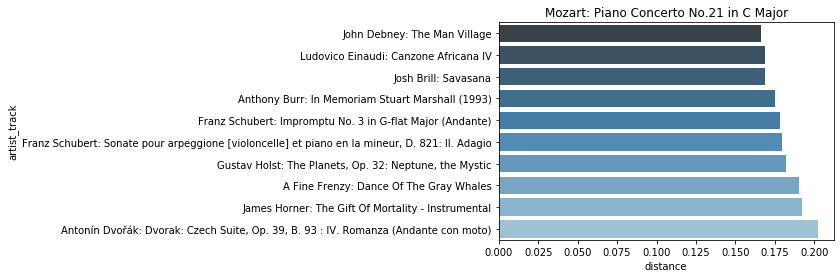

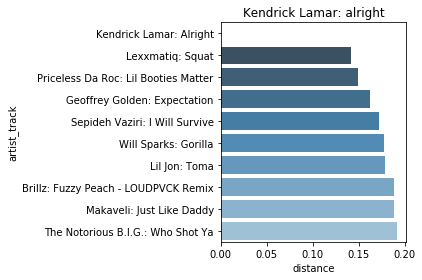

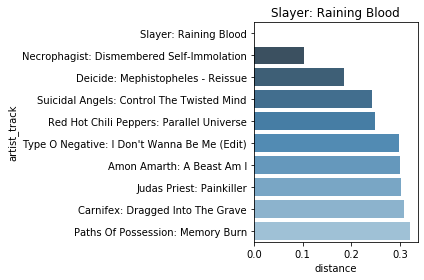

In [87]:
clusters = []

# Wolfgang Amadeus Mozart, Piano Concerto No.21 in C Major,: "spotify:track:3aX8Xg1XxtEplBZDORWmyv"
cluster, neighbors = generate_nearest_songs("spotify:track:3aX8Xg1XxtEplBZDORWmyv", playlist_clusters)
artist_track = "Mozart: Piano Concerto No.21 in C Major"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Kendrick Lamar, alright: "spotify:track:3iVcZ5G6tvkXZkZKlMpIUs"
cluster, neighbors = generate_nearest_songs("spotify:track:0ECs7wpW9157Tk5yBUGbE0", playlist_clusters)
artist_track = "Kendrick Lamar: alright"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

# Slayer, Raining Blood: "spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn"
cluster, neighbors = generate_nearest_songs("spotify:track:4Yx9Tw9dTgQ8eGCq3PRDyn", playlist_clusters)
artist_track = "Slayer: Raining Blood"
neighbors["artist_track"] = neighbors["artist_name"] + ": " + neighbors["track_name"]
clusters.append({"artist_track": artist_track, "cluster": cluster})
plot_nearest_neighbors(neighbors.head(10), artist_track)

pd.DataFrame(clusters)

In [89]:
tester = X_train.merge(playlist_data.set_index("trackid"), how="inner", on="trackid")
tester[tester["artist_name"] == "2Pac"][["artist_name", "track_name"]]


,artist_name,track_name
trackid,,
spotify:track:5MaLKRseVIV185SdzBm1I9,2Pac,Thug Luv
spotify:track:1yOedcASHco5R4m4f4zHhQ,2Pac,Whatz Ya Phone #
spotify:track:52Ak1eGaDpas3eNC3NedJe,2Pac,My Block
spotify:track:1SIwEtA6vOapGw7fA7T9Gy,2Pac,Trapped
spotify:track:075Tqgr9VfBdeWz6PMF1Ck,2Pac,Holler If Ya' Hear Me
...,...,...
spotify:track:22nvXqVGgWNvjQqKEdrJIZ,2Pac,Shorty Wanna Be A Thug
spotify:track:1QzAriSeZuHiZt5PZs5t1c,2Pac,Never Call U Bitch Again - Live
spotify:track:6uSl1oTb01LwPBaruCA5wm,2Pac,Thugz Mansion - Nas Acoustic
